In [1]:
#!conda install matplotlib -y

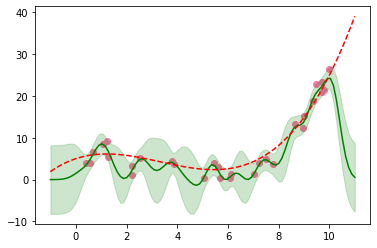

In [2]:
# ガウス過程 　-kernel: RBF（放射基底関数） - パラメータの調整

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class RBFkernel:
    def __init__(self,*param):
        self.param = list(param)

    def __call__(self,x1,x2):
        a,s,w = self.param
        return a**2*np.exp(-((x1-x2)/s)**2) + w*(x1==x2)

def y(x): # 知りたい関数の正体
    return 0.1*x**3-x**2+2*x+5

x0 = np.random.uniform(0,10,30) # 既知の点
y0 = y(x0) + np.random.normal(0,2,30) # 関数にノイズを加える
x1 = np.linspace(-1,11,101) # 探す点

kernel = RBFkernel(8,0.5,3.5) # 適当なパラメータを使うカーネル関数

k00 = kernel(*np.meshgrid(x0,x0))
k00_1 = np.linalg.inv(k00) # 逆行列
k01 = kernel(*np.meshgrid(x0,x1,indexing='ij'))
k10 = k01.T
k11 = kernel(*np.meshgrid(x1,x1))

# ここでは上述の方程式の通りのμとΣ
mu = k10.dot(k00_1.dot(y0))
sigma = k11 - k10.dot(k00_1.dot(k01))

plt.scatter(x0,y0,c='#ff77aa')
plt.plot(x1,mu,'g') # 推測された平均
plt.plot(x1,y(x1),'--r') # 本物の関数
std = np.sqrt(sigma.diagonal()) # 各点の標準偏差は共分散行列の対角成分
plt.fill_between(x1,mu-std,mu+std,alpha=0.2,color='g') # 推測された標準偏差の中の領域
plt.show()

In [3]:
#!conda install imageio -y

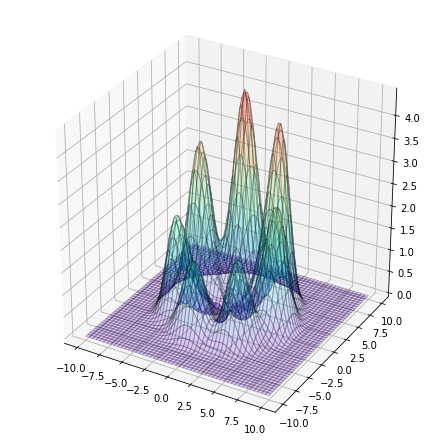

In [4]:
# MCMC -numpy -モンテカルロ法

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def fn(xy):
    x,y = xy
    return np.exp(-(5**2-(x**2+y**2))**2/250 + xy[1]/10) * (7./4-np.sin(7*np.arctan2(x,y)))

plt.figure(figsize=[6,6])
mx,my = np.meshgrid(np.linspace(-10,10,101),np.linspace(-10,10,101))
mz = fn([mx,my])
ax = plt.axes([0,0,1,1],projection='3d')
ax.plot_surface(mx,my,mz,rstride=2,cstride=2,alpha=0.2,edgecolor='k',cmap='rainbow')
plt.show()


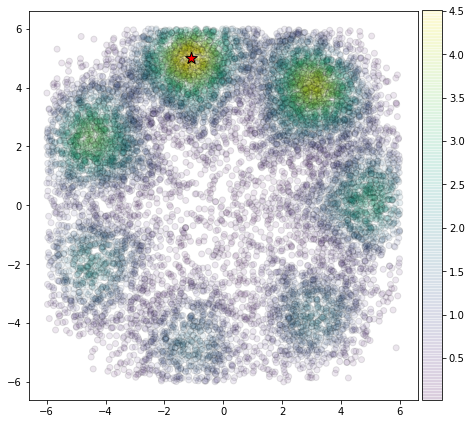

In [5]:
xy0 = np.array([3,-3]) # 開始の位置
bound = np.array([[-6,6],[-6,6]]) # 下限上限
s = (bound[:,1]-bound[:,0])/10. # 毎回どれくらい遠く移動するか
n = 16000 # 何度繰り返すか
xy = [] # 毎回の位置を格納するリスト
p = [] # 毎回の確率を格納するリスト
p0 = fn(xy0) # 開始の位置の確率
for i in range(n):
    idou = np.random.normal(0,s,2) # 移動する距離
    hazure = (xy0+idou<bound[:,0])|(xy0+idou>bound[:,1]) # 下限上限から外れたか
    while(np.any(hazure)):
        idou[hazure] = np.random.normal(0,s,2)[hazure] # 外れたものだけもう一度ランダムする
        hazure = (xy0+idou<bound[:,0])|(xy0+idou>bound[:,1])
    xy1 = xy0 + idou # 新しい位置の候補
    p1 = fn(xy1) # 新しい位置の確率
    r = p1/p0 # 新しい位置と現在の位置の確率の比率
    # 比率は1より高い場合は常に移動するが、低い場合は確率で移動する
    if(r>1 or r>np.random.random()):
        xy0 = xy1 # 現在の位置を新しい位置に移動する
        p0 = p1
        xy.append(xy0) # 新しい位置を格納
        p.append(p0) # 新しい確率を格納

xy = np.stack(xy)
x,y = xy[:,0],xy[:,1]
plt.figure(figsize=[7,6])
plt.gca(aspect=1)
plt.scatter(x,y,c=p,alpha=0.1,edgecolor='k')
plt.colorbar(pad=0.01)
plt.scatter(*xy[np.argmax(p)],s=150,c='r',marker='*',edgecolor='k') # 最大値を星で示す
plt.tight_layout()
plt.show()

In [6]:
#!conda install emcee -y

emceeはpymc3のようにたくさん分布関数を準備しておいてあるのではなく、自分で分布関数を定義しなければならないが、色々手動で書くので自由度が高いです。機能はpymc3より少ないが、単なるサンプリングをしたいだけなら十分。むしろ機能が少ないから勉強しやすいし、余計なことを覚えなくても使えます。

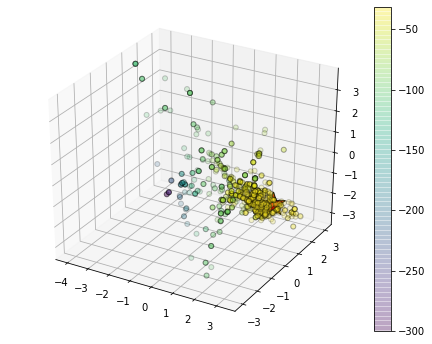

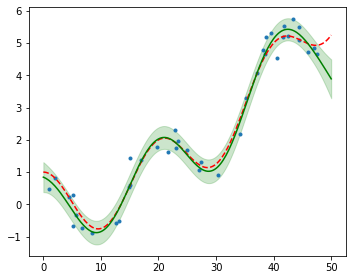

In [7]:
# モジュールを使ってガウス過程を実装する方法👇　-emceeというモジュールでMCMCを行います。

from sklearn.gaussian_process.kernels import RBF,WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
import emcee

def y(x):
    return np.cos(np.pi/10*x) + x**2/400 # 実際の関数

n = 40
x0 = np.random.uniform(0,50,n)
y0 = y(x0) + np.random.normal(0,0.25,n)
x1 = np.linspace(0,50,201)

kernel = 1*RBF()+WhiteKernel() # sklearnのカーネル
gp = GPR(kernel,alpha=0,optimizer=None) # MCMCで最適化するので、ここではoptimizer=None
gp.fit(x0[:,None],y0)

bound = np.array([[0.001,1000],[0.001,1000],[0.001,1000]]) # 下限上限
logbound = np.log(bound)

def lllh(theta): # emceeに使う分布関数
    if(np.any(theta<logbound[:,0])|np.any(theta>logbound[:,1])):
        return -np.inf
    return gp.log_marginal_likelihood(theta)

nwalker = 20
ndim = len(gp.kernel.theta)
nstep = 50
theta0 = np.random.uniform(-2,2,[nwalker,ndim]) # パラメータの初期値
sampler = emcee.EnsembleSampler(nwalker,ndim,lllh)
sampler.run_mcmc(theta0,nstep)
theta = sampler.flatchain[sampler.flatlnprobability.argmax()] # 尤度を一番高くするパラメータ
gp.kernel.theta = theta # 新しく得られたパラメータを設定する
gp.fit(x0[:,None],y0) # 新しいパラメータでもう一度学習させる

# サンプリングされたパラメータの値の分布
fig = plt.figure(figsize=[6,4.5])
ax = fig.add_axes([0,0,1,1],projection='3d')
sc = ax.scatter(*sampler.flatchain.T,alpha=0.2,s=100,c=sampler.flatlnprobability,marker='.',edgecolor='k')
plt.colorbar(sc,pad=0)
ax.scatter(*theta,s=600,c='r',edgecolor='k',marker='*') # 最大値の位置を描く

# 近似の結果
plt.figure(figsize=[5,4])
plt.plot(x0,y0,'. ')
mu,std = gp.predict(x1[:,None],return_std=True)
plt.plot(x1,y(x1),'--r')
plt.plot(x1,mu,'g')
plt.fill_between(x1,mu-std,mu+std,alpha=0.2,color='g')
plt.tight_layout()
plt.show()

In [8]:
#!conda install pymc3 -y